In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import scipy.stats as stats
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

C:\Users\Ritesh Agarwal\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
hrdf=pd.read_csv('E:/Data Science with Python/Machine Learning/2. Case Study - HR Analytics/HR_comma_sep.csv')

In [15]:
hrdf.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [16]:
hrdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [17]:
num_col_list=[key for key in dict(hrdf.dtypes) if dict(hrdf.dtypes)[key] in ['int32','float32','int64','float64']]
cat_col_list=[key for key in dict(hrdf.dtypes) if dict(hrdf.dtypes)[key] in ['object']]
print(num_col_list)
print(cat_col_list)

['satisfaction_level', 'Work_accident', 'promotion_last_5years', 'average_montly_hours', 'last_evaluation', 'number_project', 'time_spend_company', 'left']
['salary', 'department']


In [18]:
num_data = hrdf[num_col_list]
cat_data = hrdf[cat_col_list]

In [19]:
def var_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.sum(),x.mean(),x.median(),x.std(),x.var(),x.min(),x.dropna().quantile(0.01),x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75),x.dropna().quantile(0.99),x.max()],
                    index=['N','NMISS','SUM','MEAN','MEDIAN','STD','VAR','MIN','P1','P5','P10','P25','P50','P75','P99','MAX'])

summary_num=num_data.apply(lambda x: var_summary(x)).T
summary_num

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P99,MAX
satisfaction_level,14999.0,0.0,9191.89,0.612834,0.64,0.248631,0.061817,0.09,0.09,0.11,0.21,0.44,0.64,0.82,0.99,1.0
Work_accident,14999.0,0.0,2169.00,0.144610,0.00,0.351719,0.123706,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0
promotion_last_5years,14999.0,0.0,319.00,0.021268,0.00,0.144281,0.020817,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0
average_montly_hours,14999.0,0.0,3015554.00,201.050337,200.00,49.943099,2494.313175,96.00,104.00,130.00,137.00,156.00,200.00,245.00,301.00,310.0
last_evaluation,14999.0,0.0,10740.81,0.716102,0.72,0.171169,0.029299,0.36,0.39,0.46,0.49,0.56,0.72,0.87,1.00,1.0
number_project,14999.0,0.0,57042.00,3.803054,4.00,1.232592,1.519284,2.00,2.00,2.00,2.00,3.00,4.00,5.00,7.00,7.0
time_spend_company,14999.0,0.0,52470.00,3.498233,3.00,1.460136,2.131998,2.00,2.00,2.00,2.00,3.00,3.00,4.00,10.00,10.0
left,14999.0,0.0,3571.00,0.238083,0.00,0.425924,0.181411,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0


In [8]:
def cat_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.value_counts()], index=['N','NMISS','COLUMN_NAMES'])

summary_cat=cat_data.apply(lambda x: cat_summary(x)).T
summary_cat

,N,NMISS,COLUMN_NAMES
salary,14999,0,low 7316 medium 6446 high 1237 N...
department,14999,0,sales 4140 technical 2720 suppor...


In [10]:
def missing_value(x):
    x=x.fillna(x.mean())
    return x

num_data=num_data.apply(lambda x: missing_value(x))

In [10]:
def outlier_value(x):
    x=x.clip_upper(x.quantile(0.99))
    x=x.clip_lower(x.quantile(0.01))
    return x

num_data=num_data.apply(lambda x: outlier_value(x))

In [21]:
summary_1=num_data.apply(lambda x: var_summary(x)).T
summary_1

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P99,MAX
satisfaction_level,14999.0,0.0,9191.89,0.612834,0.64,0.248631,0.061817,0.09,0.09,0.11,0.21,0.44,0.64,0.82,0.99,1.0
Work_accident,14999.0,0.0,2169.00,0.144610,0.00,0.351719,0.123706,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0
promotion_last_5years,14999.0,0.0,319.00,0.021268,0.00,0.144281,0.020817,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0
average_montly_hours,14999.0,0.0,3015554.00,201.050337,200.00,49.943099,2494.313175,96.00,104.00,130.00,137.00,156.00,200.00,245.00,301.00,310.0
last_evaluation,14999.0,0.0,10740.81,0.716102,0.72,0.171169,0.029299,0.36,0.39,0.46,0.49,0.56,0.72,0.87,1.00,1.0
number_project,14999.0,0.0,57042.00,3.803054,4.00,1.232592,1.519284,2.00,2.00,2.00,2.00,3.00,4.00,5.00,7.00,7.0
time_spend_company,14999.0,0.0,52470.00,3.498233,3.00,1.460136,2.131998,2.00,2.00,2.00,2.00,3.00,3.00,4.00,10.00,10.0
left,14999.0,0.0,3571.00,0.238083,0.00,0.425924,0.181411,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.0


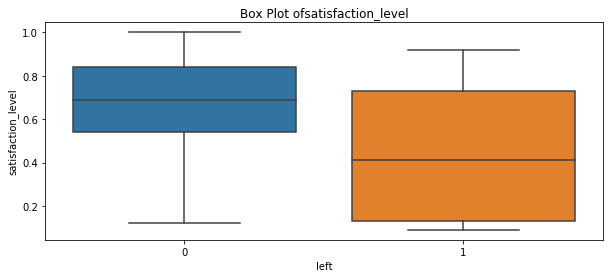

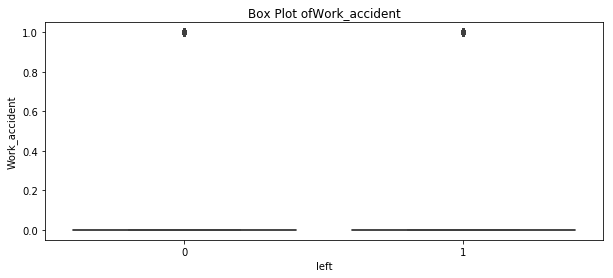

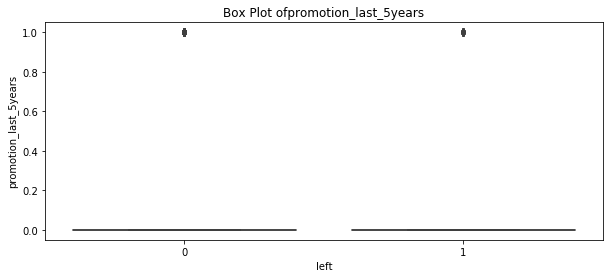

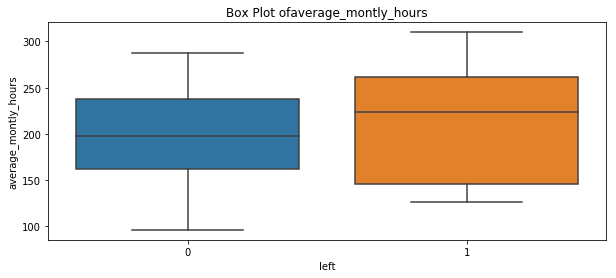

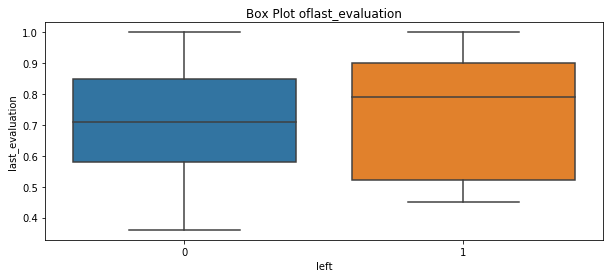

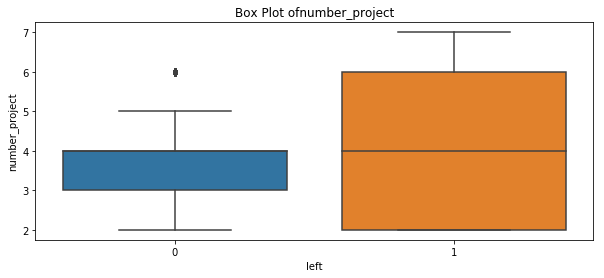

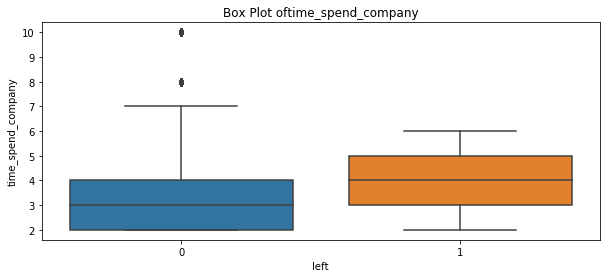

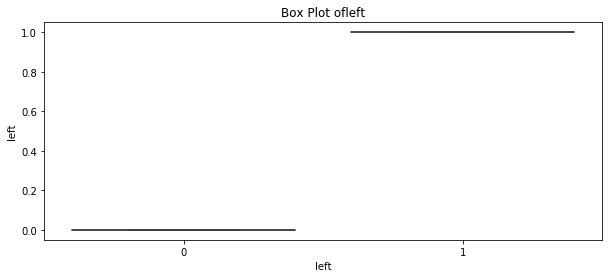

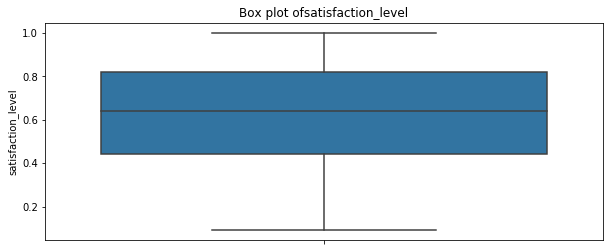

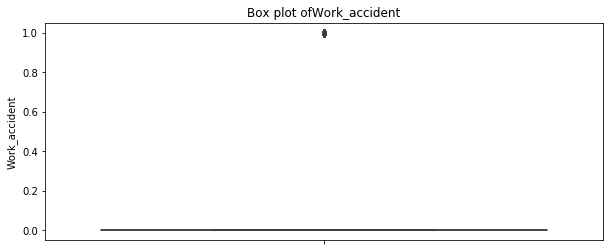

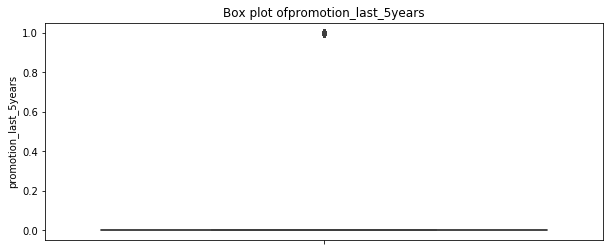

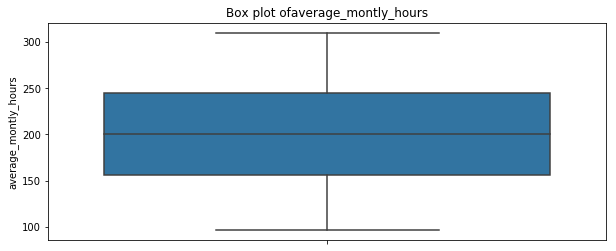

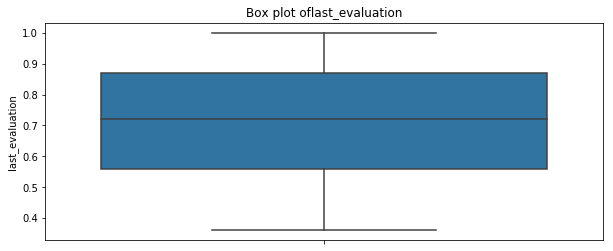

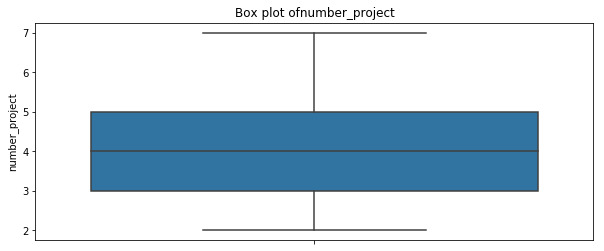

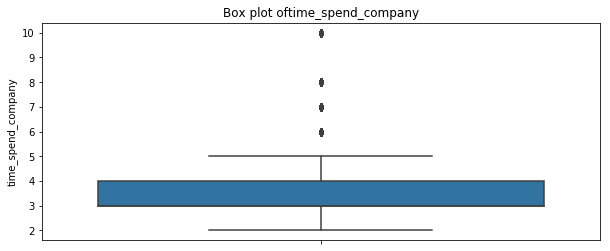

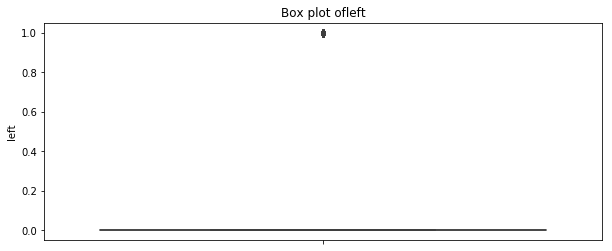

In [12]:
for n1 in num_col_list:
    fig,axes=plt.subplots(figsize=(10,4))
    sns.boxplot(x='left',y=n1,data=hrdf)
    plt.title(str('Box Plot of') + str(n1))
    
for n1 in num_col_list:
    fig,axes=plt.subplots(figsize=(10,4))
    sns.boxplot(y=n1,data=hrdf)
    plt.title(str('Box plot of') +str(n1))

In [20]:
## only 'time_spend_company' requires outlier treatment
hrdf['time_spend_company'] = hrdf['time_spend_company'].clip_upper(threshold=8)

In [26]:
chisq_df=pd.DataFrame()
for c1 in cat_col_list:
    cross_tab=pd.crosstab(hrdf[c1],hrdf['left'],margins=False)
    stats.chi2_contingency(observed=cross_tab)[1]
    temp=pd.DataFrame([c1,stats.chi2_contingency(observed=cross_tab)[0],stats.chi2_contingency(observed=cross_tab)[1]]).T
    temp.columns=(['Variable','Chi-sq','P-value'])
    chisq_df=pd.concat([chisq_df,temp],axis=0,ignore_index=True)
    
print(chisq_df)

     Variable   Chi-sq      P-value
0      salary  381.225  1.65209e-83
1  department  86.8255  7.04213e-15


In [ ]:
ttest_df=pd.DataFrame()
for n1 in num_col_list:
    ttest=ttest_ind(hrdf[hrdf['left']==1][n1],hrdf[hrdf['left']==0][n1])
    temp=pd.DataFrame(n1,ttest[0],ttest[1]).T
    temp.columns=(['Variable','T s'])